In [2]:
%matplotlib inline

# Microgrid Simulation

In this example, a sizing simulation with a basic power balance strategy is tested.

## Initialization

The project directory is initialized

In [10]:
import sys, os

PROJECT_HOME = os.getenv('PROJECT_HOME')
if not PROJECT_HOME:
    PROJECT_HOME = '/opt/datadriver/workspace/'
    
sys.path.append(PROJECT_HOME)

Time series export path initialization

In [11]:
EXPORT_PATH = '%s/data/datadriver_data/whisper/simu_sizing/' %PROJECT_HOME

Importing smartgrid libraries

In [12]:
import sys,os,os.path
import pickle
import pandas as pd
from smartgrid.microgrid.simulator import microgrid_simulator
from smartgrid.io.export_grafana import export_to_whisper

## Strategy definition

In [13]:
def my_power_balance_strategy(P_ac_dispo, P_auxiliaires, P_loads, possibilite_decharge, possibilite_recharge):
    '''
    Strategie de gestion simple
    '''
    
    # PREMIERE ETAPE : on calcule la puissance AC au niveau de l'onduleur
    #  batterie pour equilibrer la production et la consommation.
    #  P_onduleur_batterie_AC(t) = P_AC_dispo(t) - P_auxiliaires(t) - P_loads(t)
    P_onduleur_batterie_AC = P_ac_dispo - P_auxiliaires - P_loads
    P_soutirage_reseau = 0

    # DEUXIEME ETAPE : l'ensemble des cas est detaille.
    #  L'etat bas de la batterie a ete atteint. Il n'est pas possible de la
    #  decharger plus.
    if possibilite_decharge is False:
        # Si la puissance de production n'est pas suffisante pour alimenter les
        #  charges et les auxiliaires, on fait appel au reseau principal (EDF).
        if P_onduleur_batterie_AC < 0:
            P_soutirage_reseau = abs(P_onduleur_batterie_AC)
            P_onduleur_batterie_AC = 0
            s_state = 'Cas 1 : Decharge Impossible / Recharge Possible / Soutirage Reseau'
        # Dans le cas contraire, les batteries se rechargent.
        else:
            s_state = 'Cas 2 : Decharge Impossible / Recharge Possible / Recharge Batterie'
    # Dans les cas suivants, la decharge est possible.
    else:
        # L'etat haut de la batterie n'a pas ete atteint.
        if possibilite_recharge is True:
            if P_onduleur_batterie_AC < 0:
                s_state = 'Cas 3 : Decharge Possible / Recharge Possible / Decharge Batterie'
            else:
                s_state = 'Cas 4 : Decharge Possible / Recharge Possible / Recharge Batterie'
        # L'etat haut de la batterie a ete atteint. Il n'est pas possible de la recharger plus.
        else:
            if P_onduleur_batterie_AC < 0:
                s_state = 'Cas 5 : Decharge Possible / Recharge Impossible / Decharge Batterie'
            else:
                # limitation_PV = P_auxiliaires + P_loads
                s_state = 'Cas 6 : Decharge Possible / Recharge Impossible / Limitation PV'
    return P_onduleur_batterie_AC, P_soutirage_reseau, s_state


## Strategy simulation

## Strategy parameters

In [27]:
COEF_CHARGE = 1.
COEF_PV = 1.
COEF_BATTERY = 0.5
HISTORY = 1000

## Simulation

In [28]:
outputs = microgrid_simulator(COEF_CHARGE, COEF_PV, COEF_BATTERY, 
                              num_points=1000, max_history=HISTORY, strategy=my_power_balance_strategy)

In [29]:
Autoconsommation = outputs['Autoconsommation']
Autoproduction = outputs['Autoproduction']
print("Parameters Charge", COEF_CHARGE, "PV", COEF_PV, "Battery", COEF_BATTERY)
print("=> Autoconsommation ", Autoconsommation)
print("=> Autoproduction ", Autoproduction)

('Parameters Charge', 1.0, 'PV', 1.0, 'Battery', 0.5)
('=> Autoconsommation ', 0.13717505852879405)
('=> Autoproduction ', 1.0)


In [30]:
stats = pd.DataFrame(index=outputs['TU'], data={
        'P_ac_dispo': outputs['P_ac_dispo'],
        'P_limitation_PV': outputs['P_limitation_PV'],
        'productionPV_AC': outputs['productionPV_AC']    })

## Exporting results

### P_AC_DISPO

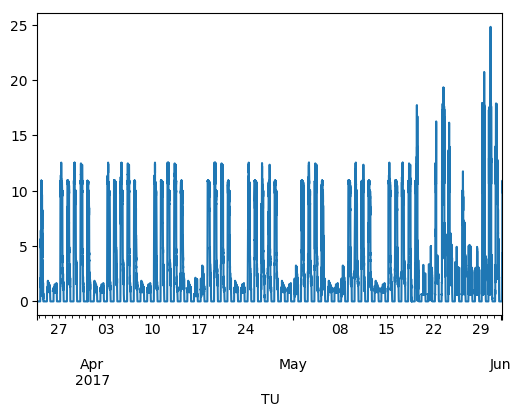

In [31]:
stats.P_ac_dispo.plot()

### P_limitation_PV

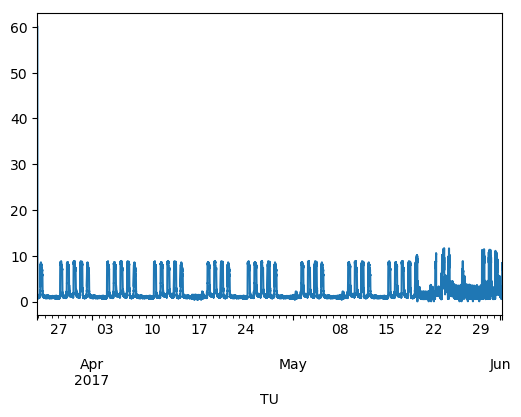

In [32]:
stats.P_limitation_PV.plot()

### productionPV_AC

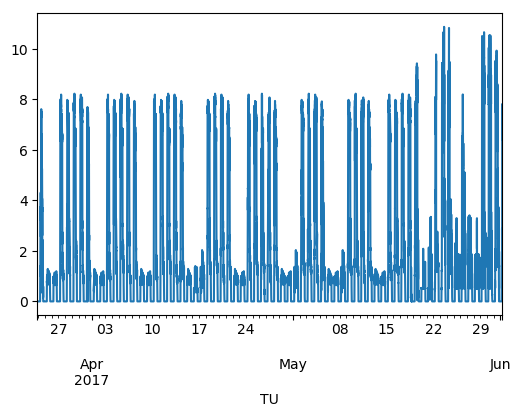

In [33]:
stats.productionPV_AC.plot()